## Comparing different recommender for library data

## Library

Loading basic python libraries:

In [1]:
import pandas as pd # to load the dataset and basic operation
import numpy as np # working with array
import matplotlib.pyplot as plt # plotting
from datetime import datetime # to calculate the age of customer
from sklearn.preprocessing import MinMaxScaler # to normalize rating
from IPython.display import HTML, display # to display html table

Importing libraries used for recommendation: 

In [2]:
#Importing Surprise library
from surprise import accuracy, Reader, Dataset, evaluate
from surprise.model_selection import KFold, cross_validate

#algorithms
from surprise import NormalPredictor, BaselineOnly, SVD, SVDpp, NMF, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, SlopeOne, CoClustering

## Data

Importing datasets

In [3]:
# artifacts return log
LoanReturnDF = pd.read_csv("libdat_palautus.csv", sep=";", encoding="latin1")

# artifacts loan log
LoanDF =pd.read_csv("libdat_laina.csv", sep=";", encoding="latin1")

# customer details
CustomerDF = pd.read_csv("libdat_asiakas_sakk.csv", sep=";", encoding="latin1")

# artifacts details
ItemDF = pd.read_csv("libdat_teos.csv", sep=";", encoding="latin1")

# language data
LanguageDF = pd.read_csv("libdat_kieli.csv", sep=";", encoding="latin1")

# terminal data
TerminalDF = pd.read_csv("libdat_terminaali.csv", sep = ";", encoding="latin1")

# material data
MaterialDF = pd.read_csv("libdat_materiaali.csv", sep=";", encoding="latin1")

# category data
CategoryDF = pd.read_csv("libdat_aiheryhma.csv", sep=";", encoding="latin1")

## Data Exploration

In [4]:
# shape of the datasets
DataSets = [LoanReturnDF, LoanDF, CustomerDF, ItemDF, LanguageDF, TerminalDF, MaterialDF, CategoryDF]
for dataset in DataSets:
    print(dataset.shape)
    print('--------------------')

(1237595, 4)
--------------------
(1550694, 4)
--------------------
(127088, 7)
--------------------
(790653, 9)
--------------------
(485, 2)
--------------------
(46, 3)
--------------------
(26, 2)
--------------------
(106, 2)
--------------------


In [5]:
# structure of customer data
CustomerDF.head()

,asiakas_id,sukupuoli,syntymaaika,lainoja_yht,lainoja_31-10-2017,asioimiskieli,postinumero
0,1024945135,mies,05.1943,836,7,fin,01280 Vantaa
1,1024959401,nainen,07.1966,42,0,fin,01710 Vantaa
2,1024962272,nainen,06.1958,471,1,fin,01360 Vantaa
3,1025005401,nainen,10.1959,11,0,fin,01350 Vantaa
4,1025015368,nainen,11.1984,141,0,fin,01200 Vantaa


In [6]:
# customer's sex distribution
CustomerDF.sukupuoli.value_counts()

nainen       75354
mies         51558
ei tietoa      163
muu             13
Name: sukupuoli, dtype: int64

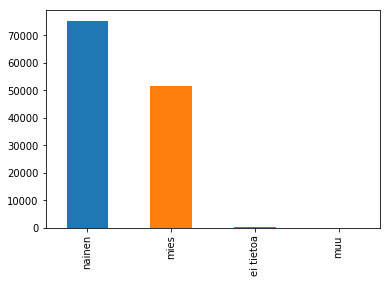

In [7]:
# ploting sex distribution
CustomerDF.sukupuoli.value_counts().plot(kind='bar')

In [8]:
# customer care language
CustomerDF.asioimiskieli.value_counts()

fin    121157
eng      4073
swe      1855
            3
Name: asioimiskieli, dtype: int64

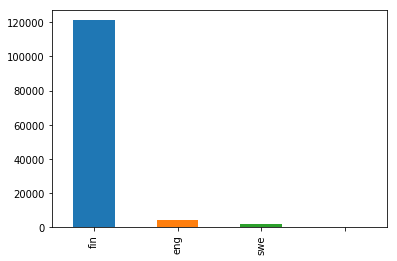

In [9]:
#customer care language plot
CustomerDF.asioimiskieli.value_counts().plot(kind='bar')

In [10]:
# function to calculate age(+/-1)
def calculate_age(b_date):
    try:
        b_date = datetime.strptime(b_date, '%d.%Y')
    except ValueError:
        b_date = datetime.strptime('01.2018', '%d.%Y')
    today = datetime.today()
    return today.year - b_date.year

In [11]:
# calculating age of the customer and placing it in a coloumn
CustomerDF['age'] = CustomerDF.syntymaaika.apply(calculate_age)

Text(0.5, 1.0, 'Age distribution of the customer')

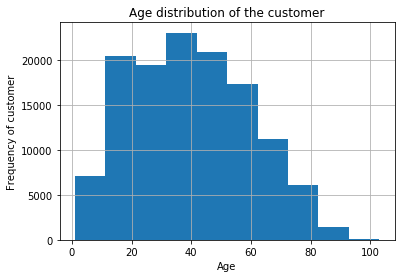

In [12]:
# age distribution of the customer
CustomerDF.age.hist()
plt.xlabel('Age')
plt.ylabel('Frequency of customer')
plt.title('Age distribution of the customer')

In [13]:
# loan log
LoanDF.head()

,asiakas_id,teos_id,aika,terminaali_id
0,1519226433,b22474390,20.07.2016 07:48:00,63
1,1519226433,b22563714,20.07.2016 07:48:00,63
2,1994357295,b21786690,20.07.2016 07:57:00,57
3,1362508335,b22293267,20.07.2016 08:06:00,38
4,1362508335,b2255838x,20.07.2016 08:06:00,38


In [14]:
# merging loan log with item dataset
LoanDF = pd.merge(ItemDF, LoanDF, on='teos_id')
# merging customer data too
LoanDF = pd.merge(CustomerDF, LoanDF, on='asiakas_id')
LoanDF.head()

,asiakas_id,sukupuoli,syntymaaika,lainoja_yht,lainoja_31-10-2017,asioimiskieli,postinumero,age,teos_id,tekija,teos,kieli_id,materiaali_id,julkaisutiedot,aiheyhma_id,ulkoasutiedot,asiasanat,aika,terminaali_id
0,1024945135,mies,05.1943,836,7,fin,01280 Vantaa,76,b10672874,NaN,Music of the gypsies,mul,3,"London : World Music Network, p1999",72.0,1 CD-Ã¤Ã¤nilevy (69 min 48 sek) + esiteliite,perinnemusiikki|romanit|mustalaismusiikki|koko...,03.08.2016 11:05:00,97
1,1024945135,mies,05.1943,836,7,fin,01280 Vantaa,76,b11076781,NaN,Tiede : Vantaa,fin,9,"Helsinki : Helsinki Media, 2001-",1.0,Kerran kuukaudessa,tiede|tieteet|tutkimus|tekniikka|biologia|hist...,19.10.2017 13:45:30,91
2,1024945135,mies,05.1943,836,7,fin,01280 Vantaa,76,b11777333,"Brodsky Quartet, esittÃ¤jÃ¤",Brodsky unlimited : A compilation of the quart...,zxx,3,"[Hamburg] : TELDEC Classics, p1991",73.0,1 CD-Ã¤Ã¤nilevy (55 min 58 s) : DDD + esiteliite,kvartetit|jousisoittimet,10.05.2017 10:17:01,98
3,1024945135,mies,05.1943,836,7,fin,01280 Vantaa,76,b12636010,"Gould, Glenn, esittÃ¤jÃ¤",Glenn Gould plays Prokofiev Shostakovich,zxx,3,"Pontelambro : Nuova Era, p1989",74.0,1 CD-Ã¤Ã¤nilevy (41 min 27 sek) + esiteliite,1930-1940-luku|1940-luku|piano|sonaatit|kvinte...,10.05.2017 10:16:57,98
4,1024945135,mies,05.1943,836,7,fin,01280 Vantaa,76,b12832984,"Haydn, Joseph, sÃ¤veltÃ¤jÃ¤",Concertos for Flute & Oboe,zxx,3,"S.l. : CBS Inc., p1985",73.0,2 CD-Ã¤Ã¤nilevyÃ¤ : ADD + esiteliite,1770-luku|1700-luku|kaksoiskonsertot|huilu|obo...,11.01.2017 10:37:00,91


In [15]:
# 10 most popular items in the entire dataset
LoanDF.teos.value_counts().head(10)

Anna : Vantaa                          2654
Hevoshullu : Vantaa                    2563
Me naiset : Vantaa                     2505
Kodin kuvalehti : Vantaa               2141
Tieteen kuvalehti : Vantaa             1929
Tieteen kuvalehti historia : Vantaa    1898
Kauneus & terveys : Vantaa             1778
Karvinen : Vantaa                      1747
Tom ja Jerry : Vantaa                  1636
Seura : Vantaa                         1619
Name: teos, dtype: int64

In [16]:
# Loan return log
LoanReturnDF.head()

,asiakas_id,teos_id,aika,terminaali_id
0,1611169252,b11833981,20.07.2016 06:45:00,39
1,1611169252,b11834171,20.07.2016 06:45:00,39
2,1647567779,b21543859,20.07.2016 06:45:00,39
3,1647567779,b22277560,20.07.2016 06:45:00,39
4,2332402432,b16915677,20.07.2016 06:45:00,39


In [17]:
# Item data
ItemDF.head()

,teos_id,tekija,teos,kieli_id,materiaali_id,julkaisutiedot,aiheyhma_id,ulkoasutiedot,asiasanat
0,b10000021,Helsingin kaupunki. Lasten pÃ¤ivÃ¤hoitovirasto,0-3 -vuotiaiden kehittÃ¤mistyÃ¶ryhmÃ¤n raportt...,fin,1,"Helsinki, 1979",22.0,[16 sivua] : nid.|teksti txt rdacontent|kÃ¤yte...,NaN
1,b10000033,NaN,007 ja kultainen ase / directed by Guy Hamilto...,mul,g,"Helsinki : FS Film, [2001]",89.0,1 DVD-levy (2 h) : vÃ¤r.,"Bond, James, fikt.|1970-luku|Iso-Britannia|jÃ¤..."
2,b10000057,NaN,007 ja kuoleman katse / directed by John Glen ...,mul,g,"Helsinki : FS Film, [2001]",89.0,1 DVD-levy (2 h 7 min) : vÃ¤r.,"Bond, James, fikt.|1980-luku|Iso-Britannia|jÃ¤..."
3,b10000069,NaN,007 ja kuoleman katse : sarjakuvaversio,fin,1,"[Tampere] : Semic, cop. 1986",92.0,50 sivua : kuvitettu|stillkuva sti rdacontent|...,sarjakuvat kaunokki|kaunokirjallisuus kaunokki
4,b10000082,NaN,007 ja kultainen silmÃ¤ / directed by Martin C...,mul,g,"Helsinki : FS Film, [2001]",89.0,1 DVD-levy (2 h 4 min) : vÃ¤ri + tekstiliite,"Bond, James, fikt.|1990-luku|Iso-Britannia|jÃ¤..."


## Preprocessing

In [18]:
#finding common item percentage between different age group
#between 30 and 40
df = LoanDF
df_30_40 = df.loc[(df['age'] >= 30) & (df['age'] <= 40)]
df_30_40.name = "dataset of users age between 30 to 40"
#between 40 and 50
df_40_50 = df.loc[(df['age'] >= 40) & (df['age'] <= 50)]
df_40_50.name = "dataset of users age between 40 to 50"

In [19]:
def findcommon(firstdf, seconddf):
    firstdf_length = len(set(firstdf.teos_id))
    seconddf_length = len(set(seconddf.teos_id))
    common_item_length = len(set(firstdf.teos_id).intersection(set(seconddf.teos_id)))
    first_percentage = round((common_item_length/firstdf_length)*100, 2)
    second_percentage = round((common_item_length/seconddf_length)*100, 2)
    print('No. of items in '+firstdf.name+' = '+str(firstdf_length))
    print('No. of items in '+seconddf.name+' = '+str(seconddf_length))
    print('No of common items between '+firstdf.name+' and '+seconddf.name+ ' = '+str(common_item_length))
    print('which is '+str(first_percentage)+'% of '+firstdf.name+' and '+str(second_percentage)+'% of '+ seconddf.name)
    
    

In [20]:
# common items between age group 30-40 and 40-50
findcommon(df_30_40,df_40_50)

No. of items in dataset of users age between 30 to 40 = 78665
No. of items in dataset of users age between 40 to 50 = 94066
No of common items between dataset of users age between 30 to 40 and dataset of users age between 40 to 50 = 51883
which is 65.95% of dataset of users age between 30 to 40 and 55.16% of dataset of users age between 40 to 50


In [21]:
# common items between different age group
data1 = [['Match(%)','10-20', '20-30', '30-40','40-50','50-60','60-70','70-80','80-90','90-100'],
        ['10-20',100,46.45,61.27,66.94,49.55,33.63,22.0,6.73,0.62],
        ['20-30',40.45,100,64.53,62.68,53.1,39.75,26.07,8.95,0.89],
        ['30-40',31.09,37.61,100,65.95,49.47,36.79,24.45,8.4,0.84],
        ['40-50',28.41,30.55,55.16,100,52.41,37.3,24.83,8.56,0.81],
        ['50-60',24.58,30.25,48.36,61.26,100,47.9,30.44,11.03,1.04],
        ['60-70',21.32,28.95,45.96,55.73,61.22,100,41.22,14.84,1.38],
        ['70-80',21.65,29.47,47.42,57.59,60.39,63.98,100,23.27,2.17],
        ['80-90',21.84,33.39,53.76,65.48,72.19,75.99,76.8,100,6.58],
        ['90-100',22.41,36.72,59.23,68.95,75.43,48.49,79.39,72.82,100],
       ]


display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data1)
       )
))

Match(%),10-20,20-30,30-40,40-50,50-60,60-70,70-80,80-90,90-100
10-20,100,46.45,61.27,66.94,49.55,33.63,22.0,6.73,0.62
20-30,40.45,100,64.53,62.68,53.1,39.75,26.07,8.95,0.89
30-40,31.09,37.61,100,65.95,49.47,36.79,24.45,8.4,0.84
40-50,28.41,30.55,55.16,100,52.41,37.3,24.83,8.56,0.81
50-60,24.58,30.25,48.36,61.26,100,47.9,30.44,11.03,1.04
60-70,21.32,28.95,45.96,55.73,61.22,100,41.22,14.84,1.38
70-80,21.65,29.47,47.42,57.59,60.39,63.98,100,23.27,2.17
80-90,21.84,33.39,53.76,65.48,72.19,75.99,76.8,100,6.58
90-100,22.41,36.72,59.23,68.95,75.43,48.49,79.39,72.82,100


Looking at the table above, it seems like taking age as pre filtering factor is safe as we can not use the whole dataset for modeling due to the computational capacity of the machine.

In [22]:
# Item popularity as computed rating
df['rating'] = df.groupby('teos_id')['teos_id'].transform('count')
round(df.rating.describe(),2)

count    1550260.00
mean         139.97
std          322.55
min            1.00
25%            9.00
50%           35.00
75%          108.00
max         2654.00
Name: rating, dtype: float64

In [23]:
# taking a part of dataset, age as prefiltering factor, lets start by 40-60, this parameter will be tuned and checked
## with other values
df1 = df.loc[(df['age'] >= 10) & (df['age'] <= 90)]
# taking only necessary parameters
newdf = df1[['teos_id', 'rating', 'asiakas_id']].copy()

In [24]:
df1.shape

(1523576, 20)

In [25]:
# renaming the coloumn to fit it to surprise library
newdf.columns = ["itemID","rating","userID"]

In [26]:
# removing the items that are borrowed only once
newdf = newdf.loc[(newdf['rating'] > 1)]

In [27]:
# there are only few items that are borrowed more than 1000 times, removing them as outlier
newdf = newdf.loc[(newdf['rating'] < 1500)]
# used only 10000 entries due to the computation reason. Increasing the size gives different result
newdf = newdf.head(10000)

In [28]:
newdf.shape

(10000, 3)

In [29]:
newdf.tail(50)

,itemID,rating,userID
11335,b22558056,182,1029334396
11336,b22558275,236,1029334396
11337,b2256892x,179,1029334396
11338,b22751087,150,1029334396
11339,b2275295x,123,1029334396
11340,b22753242,157,1029334396
11341,b22753242,157,1029334396
11342,b22753266,346,1029334396
11343,b22761287,98,1029334396
11344,b22770136,258,1029334396


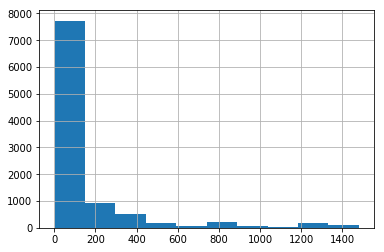

In [30]:
#displaying ratings
newdf.rating.hist()

In [31]:
#converting the rating in the scale 1-10
min_max_scaler = MinMaxScaler(feature_range=(1, 10), copy=True)
column_names_to_normalize = ['rating']
x = newdf[column_names_to_normalize].values
x_scaled = min_max_scaler.fit_transform(x)
df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = newdf.index)
newdf[column_names_to_normalize] = df_temp

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [32]:
newdf.head()

,itemID,rating,userID
0,b10672874,1.012179,1024945135
1,b11076781,6.084574,1024945135
16,b16898278,1.006089,1024945135
19,b17626699,1.042625,1024945135
21,b18083262,1.073072,1024945135


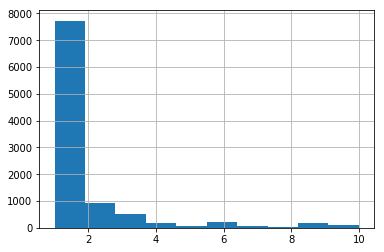

In [33]:
newdf.rating.hist()

In [34]:
# preparing data for surprise lib
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(newdf[['userID', 'itemID', 'rating']], reader)

## Evaluating Algorithms

In [35]:
# item based with cosine similarity
sim_options = {'name': 'cosine',
               'user_based': False  # compute  similarities between items
               }

In [36]:
normal_predictor = NormalPredictor()
baseline= BaselineOnly()
svd= SVD()
svdpp= SVDpp()
nmf= NMF()
knnbasic= KNNBasic(sim_options=sim_options)
knnwithmeans= KNNWithMeans(sim_options=sim_options)
knnwithzscore= KNNWithZScore(sim_options=sim_options)
knnbaseline= KNNBaseline(sim_options=sim_options)
slopeone= SlopeOne()
coclustering = CoClustering()

### Normal predictor
Algorithm predicting a random rating based on the distribution of the training set, which is assumed to be normal.

In [37]:
cross_validate(normal_predictor, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.1326  2.1766  2.0371  2.1107  2.0313  2.0977  0.0560  
MAE (testset)     1.4097  1.4648  1.3656  1.4201  1.3696  1.4059  0.0364  
Fit time          0.01    0.01    0.01    0.01    0.01    0.01    0.00    
Test time         0.02    0.02    0.02    0.02    0.06    0.03    0.02    


{'test_rmse': array([2.13257472, 2.1765868 , 2.03713548, 2.11068364, 2.03131781]),
 'test_mae': array([1.40970154, 1.46481023, 1.36560614, 1.42007252, 1.36955709]),
 'fit_time': (0.011806011199951172,
  0.011924982070922852,
  0.011499166488647461,
  0.011977910995483398,
  0.012494087219238281),
 'test_time': (0.021757125854492188,
  0.015548944473266602,
  0.016412973403930664,
  0.016109704971313477,
  0.06027483940124512)}

Rating prediction of user with userId 1029334396 for the item b10672874 :

In [38]:
uid = str('1029334396')  # raw user id (as in the ratings file). They are **strings**!
iid = str('b10672874')  # raw item id (as in the ratings file). They are **strings**!
prediction = normal_predictor.predict(uid, iid, verbose=True)

user: 1029334396 item: b10672874  r_ui = None   est = 3.49   {'was_impossible': False}


## Baseline predictor
Algorithm predicting the baseline estimate for given user and item.

In [39]:
cross_validate(baseline, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7699  0.7657  0.7836  0.7235  0.7580  0.7602  0.0201  
MAE (testset)     0.5284  0.5290  0.5302  0.5067  0.5275  0.5244  0.0089  
Fit time          0.03    0.03    0.03    0.03    0.03    0.03    0.00    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.00    


{'test_rmse': array([0.76988616, 0.76571989, 0.78364936, 0.72353258, 0.75799769]),
 'test_mae': array([0.52843452, 0.52898827, 0.53021872, 0.50665796, 0.52749169]),
 'fit_time': (0.026382923126220703,
  0.02678513526916504,
  0.026502132415771484,
  0.03130197525024414,
  0.027807950973510742),
 'test_time': (0.012319803237915039,
  0.012804031372070312,
  0.01242208480834961,
  0.012941837310791016,
  0.012237787246704102)}

Rating prediction of user with userId 1029334396 for the item b10672874 :

In [40]:
prediction = baseline.predict(uid, iid, verbose=True)

user: 1029334396 item: b10672874  r_ui = None   est = 1.80   {'was_impossible': False}


### SVD predictor
The famous SVD algorithm, as popularized by Simon Funk during the Netflix Prize.

In [41]:
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.5712  0.6095  0.6410  0.5839  0.5583  0.5928  0.0295  
MAE (testset)     0.3749  0.3676  0.3882  0.3674  0.3704  0.3737  0.0077  
Fit time          0.58    0.58    0.58    0.57    0.58    0.58    0.00    
Test time         0.02    0.01    0.01    0.01    0.01    0.02    0.00    


{'test_rmse': array([0.57119402, 0.6095161 , 0.64100328, 0.58385775, 0.55829292]),
 'test_mae': array([0.3748644 , 0.36757333, 0.38820512, 0.36739562, 0.37041549]),
 'fit_time': (0.5815989971160889,
  0.5773200988769531,
  0.5844149589538574,
  0.5736262798309326,
  0.5750129222869873),
 'test_time': (0.021315813064575195,
  0.01418304443359375,
  0.014240026473999023,
  0.014393806457519531,
  0.014544248580932617)}

Rating prediction of user with userId 1029334396 for the item b10672874 :

In [42]:
prediction = svd.predict(uid, iid, verbose=True)

user: 1029334396 item: b10672874  r_ui = None   est = 1.85   {'was_impossible': False}


### svdpp predictor
The SVD++ algorithm, an extension of SVD taking into account implicit ratings.

In [43]:
cross_validate(svdpp, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.5066  0.4955  0.5424  0.5821  0.5541  0.5361  0.0316  
MAE (testset)     0.3310  0.3261  0.3402  0.3401  0.3383  0.3351  0.0056  
Fit time          21.45   22.12   21.32   21.00   21.51   21.48   0.36    
Test time         0.15    0.14    0.15    0.15    0.14    0.15    0.00    


{'test_rmse': array([0.50663929, 0.49550522, 0.54241625, 0.58206924, 0.55407901]),
 'test_mae': array([0.33098231, 0.32609557, 0.34020877, 0.3400817 , 0.33829113]),
 'fit_time': (21.44910216331482,
  22.118531227111816,
  21.318477153778076,
  20.9997661113739,
  21.50630497932434),
 'test_time': (0.14574503898620605,
  0.14242291450500488,
  0.14516210556030273,
  0.15268778800964355,
  0.14075279235839844)}

Rating prediction of user with userId 1029334396 for the item b10672874 :

In [44]:
prediction = svdpp.predict(uid, iid, verbose=True)

user: 1029334396 item: b10672874  r_ui = None   est = 1.77   {'was_impossible': False}


### NMF predictor
A collaborative filtering algorithm based on Non-negative Matrix Factorization.

In [45]:
cross_validate(nmf, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.6434  0.6265  0.6125  0.6121  0.6296  0.6248  0.0117  
MAE (testset)     0.5148  0.5077  0.5018  0.5046  0.5195  0.5097  0.0066  
Fit time          1.07    1.07    1.10    1.12    1.05    1.08    0.03    
Test time         0.02    0.01    0.01    0.01    0.01    0.01    0.00    


{'test_rmse': array([0.64336966, 0.62645472, 0.61245184, 0.6120536 , 0.6296436 ]),
 'test_mae': array([0.51481432, 0.50765784, 0.50178921, 0.50457813, 0.51952675]),
 'fit_time': (1.0703179836273193,
  1.068734884262085,
  1.1000869274139404,
  1.1184380054473877,
  1.0478661060333252),
 'test_time': (0.015620231628417969,
  0.014505863189697266,
  0.014364957809448242,
  0.013847112655639648,
  0.013979911804199219)}

Rating prediction of user with userId 1029334396 for the item b10672874 :

In [46]:
prediction = nmf.predict(uid, iid, verbose=True)

user: 1029334396 item: b10672874  r_ui = None   est = 1.84   {'was_impossible': True, 'reason': 'User and item are unkown.'}


### KNNbaseline predictor
A basic collaborative filtering algorithm taking into account a baseline rating.

In [47]:
cross_validate(knnbaseline, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7592  0.6882  0.7293  0.7156  0.7345  0.7254  0.0233  
MAE (testset)     0.5370  0.4967  0.5102  0.4979  0.5191  0.5122  0.0149  
Fit time          3.91    2.92    2.49    2.39    2.45    2.83    0.57    
Test time         0.17    0.14    0.15    0.15    0.13    0.15    0.01    


{'test_rmse': array([0.75916377, 0.68815417, 0.72931703, 0.71559565, 0.73452387]),
 'test_mae': array([0.53701538, 0.49671685, 0.51021025, 0.49787166, 0.51909744]),
 'fit_time': (3.9077329635620117,
  2.9157540798187256,
  2.4894120693206787,
  2.3920671939849854,
  2.4501078128814697),
 'test_time': (0.16677093505859375,
  0.13987183570861816,
  0.1497037410736084,
  0.15231108665466309,
  0.12917208671569824)}

Rating prediction of user with userId 1029334396 for the item b10672874 :

In [48]:
prediction = knnbaseline.predict(uid, iid, verbose=True)

user: 1029334396 item: b10672874  r_ui = None   est = 1.85   {'was_impossible': False}


### KNNbasic predictor
A basic collaborative filtering algorithm.

In [49]:
cross_validate(knnbasic, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.4897  1.4862  1.4777  1.4075  1.6090  1.4940  0.0649  
MAE (testset)     0.9596  0.9685  0.9517  0.9399  1.0022  0.9644  0.0211  
Fit time          2.40    2.52    2.49    2.40    2.42    2.45    0.05    
Test time         0.14    0.13    0.13    0.13    0.14    0.13    0.01    


{'test_rmse': array([1.48970839, 1.48616206, 1.47773335, 1.40747723, 1.60901652]),
 'test_mae': array([0.95955517, 0.9684906 , 0.95173386, 0.93989201, 1.0022099 ]),
 'fit_time': (2.40061616897583,
  2.5154640674591064,
  2.486947774887085,
  2.4018537998199463,
  2.423434019088745),
 'test_time': (0.1383800506591797,
  0.12982892990112305,
  0.12579917907714844,
  0.1259138584136963,
  0.1356201171875)}

Rating prediction of user with userId 1029334396 for the item b10672874 :

In [50]:
prediction = knnbasic.predict(uid, iid, verbose=True)

user: 1029334396 item: b10672874  r_ui = None   est = 1.83   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}


### KNNwithmeans predictor
A basic collaborative filtering algorithm, taking into account the mean ratings of each user.

In [51]:
cross_validate(knnwithmeans, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.5779  0.5883  0.5995  0.5660  0.6115  0.5886  0.0159  
MAE (testset)     0.4356  0.4397  0.4418  0.4216  0.4623  0.4402  0.0131  
Fit time          2.45    2.68    2.41    2.44    2.40    2.48    0.11    
Test time         0.14    0.15    0.13    0.14    0.13    0.14    0.01    


{'test_rmse': array([0.57789424, 0.58833965, 0.59947316, 0.56601637, 0.6115156 ]),
 'test_mae': array([0.43559806, 0.43965526, 0.44184667, 0.42164097, 0.46225804]),
 'fit_time': (2.447639226913452,
  2.6834497451782227,
  2.409020185470581,
  2.4392378330230713,
  2.4013900756835938),
 'test_time': (0.14124011993408203,
  0.1459197998046875,
  0.1259756088256836,
  0.13715386390686035,
  0.12549400329589844)}

Rating prediction of user with userId 1029334396 for the item b10672874 :

In [52]:
prediction = knnwithmeans.predict(uid, iid, verbose=True)

user: 1029334396 item: b10672874  r_ui = None   est = 1.85   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}


### KNNwithzscore predictor
A basic collaborative filtering algorithm, taking into account the z-score normalization of each user.

In [53]:
cross_validate(knnwithzscore, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.6367  0.6258  0.6210  0.6138  0.6185  0.6231  0.0078  
MAE (testset)     0.4904  0.4839  0.4749  0.4823  0.4765  0.4816  0.0056  
Fit time          2.65    2.77    2.67    2.53    2.54    2.63    0.09    
Test time         0.14    0.14    0.14    0.16    0.14    0.14    0.01    


{'test_rmse': array([0.63672763, 0.62583665, 0.62097403, 0.61375236, 0.61845568]),
 'test_mae': array([0.4904351 , 0.48391034, 0.47487126, 0.48234681, 0.47652577]),
 'fit_time': (2.6481120586395264,
  2.772895097732544,
  2.6724438667297363,
  2.534942150115967,
  2.5388131141662598),
 'test_time': (0.13785886764526367,
  0.13820862770080566,
  0.14329290390014648,
  0.1557481288909912,
  0.13675498962402344)}

Rating prediction of user with userId 1029334396 for the item b10672874 :

In [54]:
prediction = knnwithzscore.predict(uid, iid, verbose=True)

user: 1029334396 item: b10672874  r_ui = None   est = 1.84   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}


### SlopeOne predictor
A simple yet accurate collaborative filtering algorithm.

In [55]:
cross_validate(slopeone, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SlopeOne on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7607  0.7769  0.7578  0.7566  0.7403  0.7585  0.0117  
MAE (testset)     0.6088  0.6153  0.6228  0.6076  0.6136  0.6136  0.0054  
Fit time          1.05    1.18    1.09    1.16    1.13    1.12    0.05    
Test time         0.10    0.09    0.09    0.09    0.09    0.09    0.00    


{'test_rmse': array([0.76071902, 0.77691314, 0.75783339, 0.7565935 , 0.74030618]),
 'test_mae': array([0.60876187, 0.61534837, 0.6228146 , 0.60758731, 0.61359248]),
 'fit_time': (1.0454769134521484,
  1.1777009963989258,
  1.0933492183685303,
  1.1551129817962646,
  1.1318471431732178),
 'test_time': (0.0964360237121582,
  0.08788204193115234,
  0.09347677230834961,
  0.09494495391845703,
  0.0912771224975586)}

Rating prediction of user with userId 1029334396 for the item b10672874 :

In [56]:
prediction = slopeone.predict(uid, iid, verbose=True)

user: 1029334396 item: b10672874  r_ui = None   est = 1.85   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}


### CoClustering predictor
A collaborative filtering algorithm based on co-clustering.

In [57]:
#evaluate(coclustering, data, measures=["RMSE", "MAE"])
cross_validate(coclustering, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm CoClustering on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7766  0.7596  0.7487  0.7696  0.8849  0.7879  0.0494  
MAE (testset)     0.6423  0.6305  0.6283  0.6400  0.7066  0.6495  0.0290  
Fit time          0.75    0.73    0.75    0.73    0.72    0.73    0.01    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.00    


{'test_rmse': array([0.77658145, 0.75955913, 0.74867186, 0.7695661 , 0.88491945]),
 'test_mae': array([0.64231219, 0.63048916, 0.62828117, 0.63998049, 0.70663594]),
 'fit_time': (0.7471780776977539,
  0.7275550365447998,
  0.7462620735168457,
  0.7293949127197266,
  0.7227489948272705),
 'test_time': (0.012933015823364258,
  0.012545108795166016,
  0.012220144271850586,
  0.01227116584777832,
  0.011944055557250977)}

Rating prediction of user with userId 1029334396 for the item b10672874 :

In [58]:
prediction = coclustering.predict(uid, iid, verbose=True)

user: 1029334396 item: b10672874  r_ui = None   est = 1.84   {'was_impossible': False}


## References

1. https://pandas.pydata.org/
2. https://www.numpy.org/
3. https://scikit-learn.org/stable/
4. http://surpriselib.com/